# An implementation of ROC analysis 
_**Author: Liqi Feng, Xin Liu**_

_**Date: 05/01/2016**_

_**Department of Biostatistics & Bioinformatics**_

Receiver operating characteristics (ROC) graphs are useful for organizing classifiers and visualizing their performance. ROC graphs are commonly used in medical decision making, and in recent years have been used increasingly in machine learning and data mining research. The article written by Fawcett introduces algorithms to efficiently generate ROC graphs, calculate AUC, and two ways to average ROC curves. 

The purpose of this project is to implementate the algorithms written in this paper in Python, test its application on a real classification problem and on simulated data sets. We also tried to generate functions to plot the ROC curve, optimize the code and distribute it into a library that can be used by others. 

The outline of the project is: 
- Part I: Implementation of the algorithms in paper by Fawcett 2006
    - Efficient algorithm for generating ROC points
    - Function to plot ROC points with the area under the curved shaded
    - Calculate the area under an ROC curve (AUC)
    - ROC curve averaging
        - Vertical averaging
        - Threshold averaging
     
- Part II: Optimize using cython and quantify the improvement using time
- Part III: Application of ROC analysis
    - Application to real data sets -- Pakinson's Disease
    - Application to simulated data sets
- Part IV: Wrap up functions into a module for distribution

# Part I: Implementation of the algorithms in paper by *Fawcett 2006*

### 1. Efficient algorithm for generating ROC points
- Algorithm 1 in paper by *Fawcett 2006*

In [1]:
#!pip install pandas --upgrade

In [2]:
# import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
def ROC_points(in_data):
    '''
    Function to generate ROC points for a bianry classifier on a given sample set with true lables and scores
    Input: a DataFrame with actual class label and scores
    Output:ROC points (tp rate, fp rate)
    '''
    ## sort the input data in descending order
    dat=in_data.sort_values(by=['score'],ascending=False)
    dat.index=range(dat.shape[0])
    ## compute # of positive labels and negative labels
    P=dat.label[dat.label==1].count()
    N=dat.label[dat.label==0].count()
    
    ## initialize tp and fp to 0
    tp=0
    fp=0
    ## initialize previous score to -inf
    f_prev=-np.inf
    
    ## create an empty stack
    result=[]
    
    ## compute ROC points increasing by fp rate
    for i in range(dat.shape[0]):
        if dat.score[i]!=f_prev:
            result.append((fp/N,tp/P))
            f_prev=dat.score[i]
        if dat.label[i]==1:
            tp+=1
        else:
            fp+=1
    result.append((fp/N,tp/P))
    
    return pd.DataFrame(result,columns=['fp','tp'])

- Apply the function ROC_points onto a test data set (Figure 3 in paper by Fawcett)

In [4]:
# test sample
# Figure 3 in Fawcett 2006
# class label=1: positive, label=0: negative
instance=np.array(range(20))
class_lable=np.array([1,1,0,1,1,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0])
score_=np.array([0.9,0.8,0.7,0.6,0.55,0.54,0.53,0.52,0.51,0.505,0.4,0.39,0.38,0.37,0.36,0.35,0.34,0.33,0.30,0.1])
temp={'ID':instance,'label':class_lable,'score':score_}

# put them together as a DataFrame
dat_test=pd.DataFrame(data=temp,index=range(len(instance)),columns=['ID','label','score'])

# shuffle the order
ind=np.random.choice(range(len(instance)),size=len(instance),replace=False)
dat_test=dat_test.iloc[ind]

#ind_order=np.argsort()
dat_test.sort_values(by=['score'],ascending=False).head()

,ID,label,score
0,0,1,0.90
1,1,1,0.80
2,2,0,0.70
3,3,1,0.60
4,4,1,0.55


In [5]:
# apply the function on the above test data set
points=ROC_points(dat_test)
# inspect the output value
points.head()

,fp,tp
0,0.0,0.0
1,0.0,0.1
2,0.0,0.2
3,0.1,0.2
4,0.1,0.3


### Function to plot ROC points with the area under the curved shaded
- The 45 degree line is plotted in red. A classifier does random guessing will generate a ROC curve lined up with the 45 degree line

In [6]:
def roc_graph(input_rates,title=''):
    '''
    Function to plot the ROC curve and the shaded the area under the curve
    input rates: the ROC points of a classification result
    return: None, plot is generated
    '''
    # import necessary packages
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    points=input_rates
    
    fig, ax = plt.subplots()
    # plot the roc curve
    plt.plot(points.fp,points.tp,'o-')
    
    # set axis labels and title
    plt.xlabel('False positive rate',fontsize=15)
    plt.ylabel('True positive rate',fontsize=15)
    plt.title(title,fontsize=20)
    
    # shape the area under curve
    verts =  [(points.fp[0], 0)]+list(zip(points.fp,points.tp))+[(points.fp[len(points.fp)-1], 0)]
    poly = plt.Polygon(verts, facecolor='0.8', edgecolor='0.5')
    ax.add_patch(poly)
    
    # plot the 45 degree line in red
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x,'r')

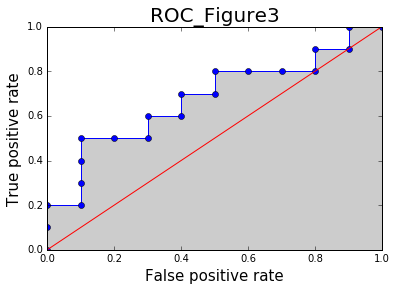

In [7]:
roc_graph(points,'ROC_Figure3')

### 2. Calculate the area under an ROC curve (AUC)
- Algorithm 2 in paper by *Fawcett 2006*

In [8]:
def TRAPEZOID_AREA(x1,x2,y1,y2):
        '''
        Function to calculate the trapezoid area  
        Input: four vertex of the trapezoid 
        Output: the area of the trapezoid
        '''
        base = abs(x1-x2)
        height = (y1+y2)/2
        return base*height

In [9]:
def AUC(in_data):
    '''
    Function to calculate the area under an ROC curve 
    Input: a DataFrame with actual class label and scores
    Output: A, the area under the ROC curve. 0<A<1.0 
    '''
    ## sort the input data in descending order
    dat=in_data.sort_values(by=['score'],ascending=False)
    dat.index=range(dat.shape[0])
    ## compute # of positive labels and negative labels
    P=dat.label[dat.label==1].count()
    N=dat.label[dat.label==0].count()
    
    ## initialize tp and fp to 0
    tp=0
    fp=0
    
    ## initialize previous tp and fp to -inf
    tp_prev=0
    fp_prev=0
    
    ## initialize the AUC score to 0
    A = 0
    
    ## initialize previous score to -inf
    f_prev=-np.inf
    
    ## compute ROC points increasing by fp rate
    for i in range(dat.shape[0]):
        if dat.score[i]!=f_prev:
            A += TRAPEZOID_AREA(fp,fp_prev,tp,tp_prev)
            f_prev = dat.score[i]
            fp_prev = fp
            tp_prev = tp
               
        if dat.label[i]==1:
            tp+=1
        else:
            fp+=1
    
    A = A+TRAPEZOID_AREA(N,fp_prev,N,tp_prev)
    A = A/(P*N) # scale from P · N onto the unit square
    
    return A

- Apply the function auc onto a test data set (Figure 3 in paper by Fawcett)

In [10]:
# test sample
# Figure 3 in Fawcett 2006
# class label=1: positive, label=0: negative
instance=np.array(range(20))
class_lable=np.array([1,1,0,1,1,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0])
score_=np.array([0.9,0.8,0.7,0.6,0.55,0.54,0.53,0.52,0.51,0.505,0.4,0.39,0.38,0.37,0.36,0.35,0.34,0.33,0.30,0.1])
temp={'ID':instance,'label':class_lable,'score':score_}

# put them together as a matrix
dat_test=pd.DataFrame(data=temp,index=range(len(instance)),columns=['ID','label','score'])

In [11]:
AUC(dat_test)

0.68000000000000005

### 3. ROC curve averaging

When cross validation is done and clustering result of multiple test data sets are obtained, one might want to get a combined information on all the test data sets - averaging multiple ROC curves. There are two ways of averaging multiple ROC curves:

- Verticle averaging: Algorithm 3 in paper by _Fawcett 2006_
- Threshold averaging: Algorithm 4 in paper by _Fawcett 2006_


### Verticle averaging
For a fixed false positive rate, find the maximum true postive rate or the interpolated true positive rate of every curve. The averaging is done by taking the mean of the true positive rate computed above for all ROC curves for any given false positive rate

In [12]:
def INTERPOLATE(ROCP1,ROCP2,X):
    '''
    Function to compute the slope for interpolation
    Input: two ROC curve points(ROCP1,ROCP2)
           X: target false postivie rate (FPR) 
    Return: The interpolated true positive rate for the given FPR
    '''
    
    slope=(ROCP2.tp-ROCP1.tp)/(ROCP2.fp-ROCP1.fp)
    return ROCP1.tp+slope*(X-ROCP1.fp)

In [13]:
def TPR_FOR_FPR(fpr_sample,ROC,npts):
    '''
    Function to find the largest true positive rate (TPR) for a given false positive rate (FPR)
    Input: fpr_sample (false positive rate fixed)
           ROC (a set of ROC points)
           npts(number of points in ROC)
    Output: The largest TPR or the interpolated TPR for the given FPR in a ROC curve
    '''
    i=1
    while(i<npts and ROC.fp[i] <= fpr_sample):
        i+=1
    
    if ROC.fp[i-1]==fpr_sample:
        return ROC.tp[i-1]
    else:
        return INTERPOLATE(ROC.ix[i-1],ROC.ix[i],fpr_sample)

In [14]:
def verticle_averaging(sample,ROCS,*karg):
    '''
    Function to compute the verticle averaging ROC points for input points of ROC curves
    Input:sample(number of false positive samples, the number of points along the x axis of the averaged ROC curve),
          ROCS(a list of multiple ROC curves, each curve is  stored in DataFrame and has 2 components:fp and tp)
    Output: the averaged ROC points
    '''

    # create an empty array to record result
    result=[]
    # number of roc cruves
    nrocs=len(ROCS)
    
    for fpr_sample in np.arange(0,(1+1/sample),1/sample):
        tprsum=0
        for i in range(nrocs):
            tprsum+=TPR_FOR_FPR(fpr_sample,ROCS[i],ROCS[i].shape[0])
        result.append((fpr_sample,tprsum/nrocs))
    #result.append((1,1))
    return pd.DataFrame(result,columns=['fp','tp'])

In [15]:
# create a test data set
# repeat points 3 times into a list
l1=[points,points,points]
for i in l1:
    print(i.shape)

(21, 2)
(21, 2)
(21, 2)


### Compute the vertical averaging curve on the list of test data set
- 10 samples of false positive rates are considered

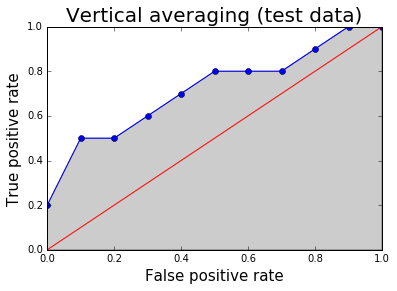

In [16]:
averaged_verticle=verticle_averaging(10,l1)
roc_graph(averaged_verticle,title='Vertical averaging (test data)')

In [17]:
# inspect the vertical averaged ROC points
print(points,"\n", averaged_verticle)

     fp   tp
0   0.0  0.0
1   0.0  0.1
2   0.0  0.2
3   0.1  0.2
4   0.1  0.3
5   0.1  0.4
6   0.1  0.5
7   0.2  0.5
8   0.3  0.5
9   0.3  0.6
10  0.4  0.6
11  0.4  0.7
12  0.5  0.7
13  0.5  0.8
14  0.6  0.8
15  0.7  0.8
16  0.8  0.8
17  0.8  0.9
18  0.9  0.9
19  0.9  1.0
20  1.0  1.0 
      fp   tp
0   0.0  0.2
1   0.1  0.5
2   0.2  0.5
3   0.3  0.6
4   0.4  0.7
5   0.5  0.8
6   0.6  0.8
7   0.7  0.8
8   0.8  0.9
9   0.9  1.0
10  1.0  1.0


### Threshold averaging 

- when fixing the false positive rate is not realistic, one might consider average over thresholds
- average ROC curves for different classifiers are meaningless because the ranges of threshold are different

In [18]:
def ROC_POINT_AT_THRESHOLD(ROC,thresh):
    '''
    Function to compute ROC point for a given threshold
    Input: ROC(ROC curve)
           thresh (threshold value)
    Output: ROC point at the given threshold
    '''
    
    for i in range(ROC.shape[0]):
        if ROC.score[i]<thresh:
            break    
    return ROC.ix[i]

In [19]:
def threshold_averaging(n_sample,ROCS,*karg):
    '''
    Function to compute the average ROC points based on threshold values
    Input: n_sample(number of thresholds considered)
           ROCS(a list of ROC curves, **** BUT ***** there must be a threshold column attached in every ROC curve)
    Output: ROC points of a threshold averaging curve
    '''
    
    # creat an empty array to store result
    # result consists of a set of points on ROC curve
    result=[]
    
    
    # create an empty numpy array to store all clustering score
    score=np.empty(1)
    for points in ROCS:
        score=np.r_[score,points.score]
    # sort the score in descending order    
    score=score[np.argsort(-score)]
    
    
    for tidx in np.arange(0,len(score),int(len(score)/n_sample)):
        fprsum=0
        tprsum=0
        for ROC in ROCS:
            p=ROC_POINT_AT_THRESHOLD(ROC,score[tidx])
            fprsum+=p.fp
            tprsum+=p.tp
        result.append((fprsum/len(ROCS),tprsum/len(ROCS)))
    
    return pd.DataFrame(result,columns=['fp','tp'])

In [20]:
# generate a test data set with thresholds
dat_test2=dat_test.sort_values(by=['score'],ascending=False)
points2=ROC_points(dat_test2)
## create a test data set with clustering score assigned to every ROC point of a ROC curve
points2['score']=(np.r_[np.inf,dat_test2.score])
points2
l2=[points2,points2]

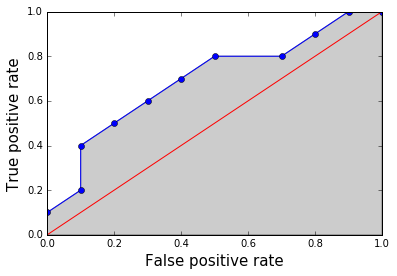

In [21]:
# applied the threshold_averaging funciton onto the above test data set
threshold_averaging(10,l2)
roc_graph(threshold_averaging(10,l2))

In [22]:
def roc_with_threshold(ROC,score):
    '''
    Helper function to attach threshold to the computed ROC curve
    Input: ROC (computed ROC points, in the order of increasing fp rate)
           score: the score array of the corresponding instances
    Output: ROC points with corresponding threshold values
    '''
    # sort the score in decreasing order
    score_ordered=score.sort_values(ascending=False)

    ROC['score']=np.r_[np.inf,score_ordered]

    return ROC

In [23]:
roc_with_threshold(points,dat_test.score).head()

,fp,tp,score
0,0.0,0.0,inf
1,0.0,0.1,0.900000
2,0.0,0.2,0.800000
3,0.1,0.2,0.700000
4,0.1,0.3,0.600000


# Part II. Optimize using cython and quantify the improvement using time

Try to optimize using cython. The improvement is not obvious since we use a lot of data frame manipulation.

In [24]:
import time
%load_ext cython

In [25]:
%%cython -a
import pandas as pd
import numpy as np
def ROC_points_cython(in_data):
    '''
    Function to generate ROC points for a bianry classifier on a given sample set with true lables and scores
    Input: a DataFrame with actual class label and scores
    Output:ROC points (tp rate, fp rate)
    '''
    ## sort the input data in descending order
    dat=in_data.sort_values(by=['score'],ascending=False)
    dat.index=range(dat.shape[0])
    ## compute # of positive labels and negative labels
    P=dat.label[dat.label==1].count()
    N=dat.label[dat.label==0].count()
    
    ## initialize tp and fp to 0
    tp=0
    fp=0
    ## initialize previous score to -inf
    f_prev=-np.inf
    
    ## create an empty stack
    result=[]
    
    ## compute ROC points increasing by fp rate
    for i in range(dat.shape[0]):
        if dat.score[i]!=f_prev:
            result.append((fp/N,tp/P))
            f_prev=dat.score[i]
        if dat.label[i]==1:
            tp+=1
        else:
            fp+=1
    result.append((fp/N,tp/P))
    
    return pd.DataFrame(result,columns=['fp','tp'])

In [26]:
# compare performance

# python version
start=time.clock()
ROC1=ROC_points(dat_test)
time1=time.clock()-start

# numba version
start=time.clock()
ROC2=ROC_points_cython(dat_test)
time2=time.clock()-start

print("speed up ratio:",time1/time2)

speed up ratio: 0.876434640035783


### vertical averaging

In [27]:
%%cython -a
import numpy as np
import pandas as pd

def INTERPOLATE_cython(ROCP1,ROCP2,X):
    '''
    Function to compute the slope for interpolation
    Input: two ROC curve points(ROCP1,ROCP2)
           X: target false postivie rate (FPR) 
    Return: The interpolated true positive rate for the given FPR
    '''
    
    slope=(ROCP2.tp-ROCP1.tp)/(ROCP2.fp-ROCP1.fp)
    return ROCP1.tp+slope*(X-ROCP1.fp)


def TPR_FOR_FPR_cython(fpr_sample,ROC,npts):
    '''
    Function to find the largest true positive rate (TPR) for a given false positive rate (FPR)
    Input: fpr_sample (false positive rate fixed)
           ROC (a set of ROC points)
           npts(number of points in ROC)
    Return: The largest TPR or the interpolated TPR for the given FPR in a ROC curve
    '''
    i=1
    while(i<npts and ROC.fp[i] <= fpr_sample):
        i+=1
    
    if ROC.fp[i-1]==fpr_sample:
        return ROC.tp[i-1]
    else:
        return INTERPOLATE_cython(ROC.ix[i-1],ROC.ix[i],fpr_sample)
    
    
def verticle_averaging_cython(sample,ROCS,*karg):
    '''
    Function to compute the verticle averaging ROC points for input points of ROC curves
    Input:sample(number of false positive samples, the number of points along the x axis of the averaged ROC curve),
          ROCS(a list of multiple ROC curves, each curve is  stored in DataFrame and has 2 components:fp and tp)
    Output: the averaged ROC points
    '''

    # create an empty array to record result
    result=[]
    # number of roc cruves
    nrocs=len(ROCS)
    
    for fpr_sample in np.arange(0,(1+1/sample),1/sample):
        tprsum=0
        for i in range(nrocs):
            tprsum+=TPR_FOR_FPR_cython(fpr_sample,ROCS[i],ROCS[i].shape[0])
        result.append((fpr_sample,tprsum/nrocs))
    #result.append((1,1))
    return pd.DataFrame(result,columns=['fp','tp'])


In [28]:
# compare performance

# python version
start=time.clock()
ROC1=verticle_averaging(10,l1)
time1=time.clock()-start

# numba version
start=time.clock()
ROC2=verticle_averaging_cython(10,l1)
time2=time.clock()-start

print("speed up ratio:",time1/time2)

speed up ratio: 1.486212342079677


### Threshold averaging

In [29]:
%%cython -a
import numpy as np
import pandas as pd

def ROC_POINT_AT_THRESHOLD_cython(ROC,thresh):
    '''
    Function to compute ROC point for a given threshold
    Input: ROC(ROC curve)
           thresh (threshold value)
    Output: ROC point at the given threshold
    '''
    
    for i in range(ROC.shape[0]):
        if ROC.score[i]<thresh:
            break    
    return ROC.ix[i]


def threshold_averaging_cython(n_sample,ROCS,*karg):
    '''
    Function to compute the average ROC points based on threshold values
    Input: n_sample(number of thresholds considered)
           ROCS(a list of ROC curves, **** BUT ***** there must be a threshold column attached in every ROC curve)
    Output: ROC points of a threshold averaging curve
    '''
    
    # creat an empty array to store result
    # result consists of a set of points on ROC curve
    result=[]
    
    
    # create an empty numpy array to store all clustering score
    score=np.empty(1)
    for points in ROCS:
        score=np.r_[score,points.score]
    # sort the score in descending order    
    score=score[np.argsort(-score)]
    
    
    for tidx in np.arange(0,len(score),int(len(score)/n_sample)):
        fprsum=0
        tprsum=0
        for ROC in ROCS:
            p=ROC_POINT_AT_THRESHOLD_cython(ROC,score[tidx])
            fprsum+=p.fp
            tprsum+=p.tp
        result.append((fprsum/len(ROCS),tprsum/len(ROCS)))
    
    return pd.DataFrame(result,columns=['fp','tp'])

In [30]:
# compare performance

# python version
start=time.clock()
ROC1=threshold_averaging(10,l2)
time1=time.clock()-start

# numba version
start=time.clock()
ROC2=threshold_averaging_cython(10,l2)
time2=time.clock()-start

print("speed up ratio:",time1/time2)

speed up ratio: 1.5222868880520197


# Part III. Application of ROC analysis 
- Apply to real data sets
- Apply to simulated data sets

### 1. Application to real data sets -- Pakinson's Disease 

In this application of our algorithom of generating ROC curve to real data sets, we chose a famous classification problem from the UCI Machine Learning Repository http://archive.ics.uci.edu/ml/. 

This dataset is composed of a range of biomedical voice measurements from 31 people, 23 with Parkinson's disease (PD). Each column in the table is a particular voice measure, and each row corresponds to one of voice recording of an individual ("name" column). The main aim of the study is to classify the PD disease status of patients based on voice meansurements. The disease status of every individual is denoted by the "status" column which is set to 0 for healthy and 1 for PD.

The data set has been randomly splitted into two parts: a training set (with 150 voice recordings) and a validation set (with 45 voice recordings). We fitted a regularized logistic regression with 'l1' norm to the training set, and generated "score" (i.e. probability of status 1) for the testing data set. 

Then the testing data set with its true label -- "status" and its predicted probability -- "score" can be used to test our algorithm. After plotting the ROC curve and calculating the AUC using algorithm in paper by *Fawcett 2006*, we compared them with the results generated by "sklearn.metrics.roc_curve" package, which is described here: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve.

In [31]:
parkinson_train = pd.read_csv('./Pakinson_data/dat.train.csv')
parkinson_train.shape

(150, 24)

In [32]:
parkinson_test = pd.read_csv('./Pakinson_data/dat.test.csv')
parkinson_test.shape

(45, 24)

In [33]:
parkinson_train.head()

,name,MDVP.Fo.Hz.,MDVP.Fhi.Hz.,MDVP.Flo.Hz.,MDVP.Jitter...,MDVP.Jitter.Abs.,MDVP.RAP,MDVP.PPQ,Jitter.DDP,MDVP.Shimmer,...,Shimmer.DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S08_3,180.198,201.249,175.456,0.00284,0.00002,0.00153,0.00166,0.00459,0.01444,...,0.02177,0.00231,26.738,1,0.403884,0.766209,-6.452058,0.212294,2.269398,0.141929
1,phon_R01_S17_2,223.365,238.987,98.664,0.00264,0.00001,0.00154,0.00151,0.00461,0.01906,...,0.03039,0.00301,26.138,0,0.447979,0.686264,-7.293801,0.086372,2.321560,0.098555
2,phon_R01_S02_2,107.332,113.840,104.315,0.00290,0.00003,0.00144,0.00182,0.00431,0.01567,...,0.02487,0.00344,26.892,1,0.637420,0.763262,-6.167603,0.183721,2.064693,0.163755
3,phon_R01_S25_3,149.689,160.368,133.608,0.00257,0.00002,0.00116,0.00134,0.00349,0.01346,...,0.01979,0.00578,27.421,1,0.365488,0.719974,-6.997403,0.210279,1.994387,0.112878
4,phon_R01_S19_2,112.014,588.518,107.024,0.00533,0.00005,0.00268,0.00329,0.00805,0.02448,...,0.04120,0.00623,24.178,1,0.509127,0.789532,-5.389129,0.306636,1.928708,0.225461


In [34]:
y_train = parkinson_train.ix[:, 'status']
X_train = parkinson_train.ix[:,1:].drop('status',axis=1)
y_test = parkinson_test.ix[:, 'status']
X_test = parkinson_test.ix[:,1:].drop('status',axis=1)

In [35]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(penalty='l1',multi_class='ovr')
classifier.fit(X_train, y_train)
score = classifier.predict_proba(X_test)
score = score[:,1] 
score

array([ 0.97975401,  0.9896271 ,  0.97296349,  0.87352297,  0.94920155,
        0.22350085,  0.27205024,  0.54642356,  0.56642742,  0.9180405 ,
        0.88551962,  0.87868383,  0.69182061,  0.8101498 ,  0.76194917,
        0.96544584,  0.99249217,  0.70919332,  0.97513739,  0.611996  ,
        0.57013281,  0.36756233,  0.72874428,  0.77354763,  0.97588312,
        0.66274248,  0.4109961 ,  0.71154967,  0.91024246,  0.58085025,
        0.74357956,  0.99960408,  0.9989782 ,  0.94961928,  0.99917768,
        0.98814528,  0.99548642,  0.9768705 ,  0.99108087,  0.89578903,
        0.94162864,  0.14538762,  0.94937229,  0.63179101,  0.80782708])

In [36]:
ID = parkinson_test.ix[:,'name']
label = parkinson_test.ix[:,'status']
score = score
parkinson_test_roc = pd.DataFrame({'ID': ID, 'label': label, 'score':score})
parkinson_test_roc.head()

,ID,label,score
0,phon_R01_S01_3,1,0.979754
1,phon_R01_S01_4,1,0.989627
2,phon_R01_S02_4,1,0.972963
3,phon_R01_S04_4,1,0.873523
4,phon_R01_S05_4,1,0.949202


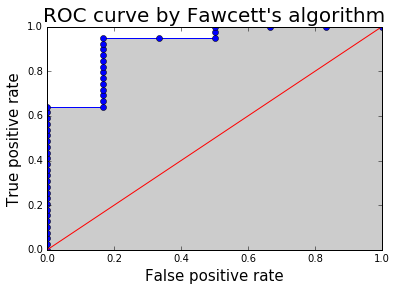

In [37]:
points = ROC_points(parkinson_test_roc)
roc_graph(points,"ROC curve by Fawcett's algorithm")

In [38]:
AUC(parkinson_test_roc)

0.85256410256410253

Plot ROC curve, calculate AUC using scikit-learn.

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score

In [40]:
fpr, tpr, thres = roc_curve(np.array(label), score, pos_label=1)
fpr,tpr,thres

(array([ 0.        ,  0.        ,  0.16666667,  0.16666667,  0.5       ,
         0.5       ,  1.        ]),
 array([ 0.02564103,  0.64102564,  0.64102564,  0.94871795,  0.94871795,
         1.        ,  1.        ]),
 array([ 0.99960408,  0.8101498 ,  0.80782708,  0.57013281,  0.54642356,
         0.36756233,  0.14538762]))

In [41]:
skrocpoints = pd.DataFrame({'fp':fpr,'tp':tpr})

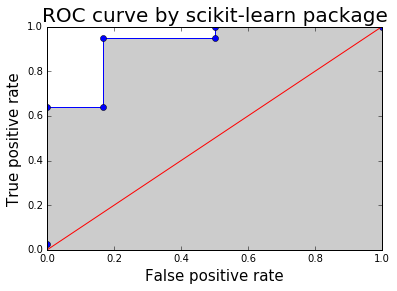

In [42]:
roc_graph(skrocpoints,'ROC curve by scikit-learn package')

In [43]:
roc_auc_score(label, score)

0.92307692307692313

From the above comparison we can see that, the algorithm of efficiently generating ROC curve can produce exactly the same result as an existing package in scikit-learn. The only difference is that our algorithm can produce more informative information by outputing more false-positive rate, true-positive rate pairs. This is essentially good for making judgement of a classification algorithm. 

In terms of the AUC of a ROC curve, the existing package yields a slightly greater value (0.9231>0.8526) than our algorithm does. The algorithm adds successive areas of trapezoids rather than rectangles in order to average the effect between points, as illustrated in Fig. 6 in paper by *Fawcett 2006*. 

### 2. Application to simulated data sets
In this section we want to simulate data sets with both balanced labels (1:1 ratio) and imbalanced labels to see wheter the algorithm produce same ROC curves. Considering two situations, we randomly sampled with replacement from the Parkinson test data set:

- 1) The first simulated data set contains 500 true positive labels, and 5 negative labels (inbalanced case 100:1).

- 1) The first simulated data set contains 50 true positive labels, and 5 negative labels (inbalanced case 10:1).

- 2) The second simulated data set contains 5 true positive labels, and 5 negative labels (balanced case 1:1).

Notice that the classifier and the underlying concept does not change, only the class distribution is different. We first generate and plot the ROC curve, and then compare them to the precision-recall curve. 

In [44]:
idx_positive = parkinson_test_roc.label==1
idx_negative = parkinson_test_roc.label==0
positive = parkinson_test_roc.ix[idx_positive,:]
negative = parkinson_test_roc.ix[idx_negative,:]

In [45]:
np.random.seed(30)
### 500 true positive labels, 5 true negative labels
simpos = np.random.randint(0,39,size=500)
simneg = np.random.randint(0,6,size=5)
simdata1 = positive.iloc[simpos].append(negative.iloc[simneg])
simpoints1 = ROC_points(simdata1)
#roc_graph(simpoints,'500 P, 5 N')
simpoints1['pre']=simpoints1['tp']/(simpoints1['tp']+simpoints1['fp'])
simpoints1['rec']=simpoints1['tp']/(sum(simdata1['label']==1))
AUC(simdata1)

0.80179999999999996

In [46]:
### 50 true positive labels, 5 true negative labels
simpos = np.random.randint(0,39,size=50)
simneg = np.random.randint(0,6,size=5)
simdata2 = positive.iloc[simpos].append(negative.iloc[simneg])
simpoints2 = ROC_points(simdata2)
#roc_graph(simpoints,'50 P, 5 N')
simpoints2['pre']=simpoints2['tp']/(simpoints2['tp']+simpoints2['fp'])
simpoints2['rec']=simpoints2['tp']/(sum(simdata2['label']==1))
AUC(simdata2)

0.82599999999999996

In [47]:
### 50 true positive labels, 50 true negative labels
simpos = np.random.randint(0,39,size=5)
simneg = np.random.randint(0,6,size=5)
simdata3 = positive.iloc[simpos].append(negative.iloc[simneg])
simpoints3 = ROC_points(simdata3)
#roc_graph(simpoints, '5 P, 5 N')
simpoints3['pre']=simpoints3['tp']/(simpoints3['tp']+simpoints3['fp'])
simpoints3['rec']=simpoints3['tp']/(sum(simdata3['label']==1))
AUC(simdata3)

0.76000000000000001

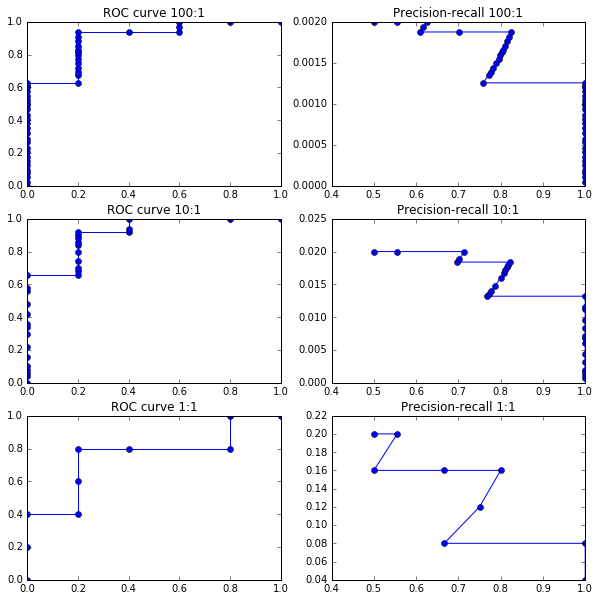

In [48]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(10, 10)
ax[0,0].plot(simpoints1.fp,simpoints1.tp,'o-')
ax[0,0].set_title('ROC curve 100:1')
ax[0,1].plot(simpoints1.pre,simpoints1.rec,'o-')
ax[0,1].set_title('Precision-recall 100:1')
ax[1,0].plot(simpoints2.fp,simpoints2.tp,'o-')
ax[1,0].set_title('ROC curve 10:1')
ax[1,1].plot(simpoints2.pre,simpoints2.rec,'o-')
ax[1,1].set_title('Precision-recall 10:1')
ax[2,0].plot(simpoints3.fp,simpoints3.tp,'o-')
ax[2,0].set_title('ROC curve 1:1')
ax[2,1].plot(simpoints3.pre,simpoints3.rec,'o-')
ax[2,1].set_title('Precision-recall 1:1')

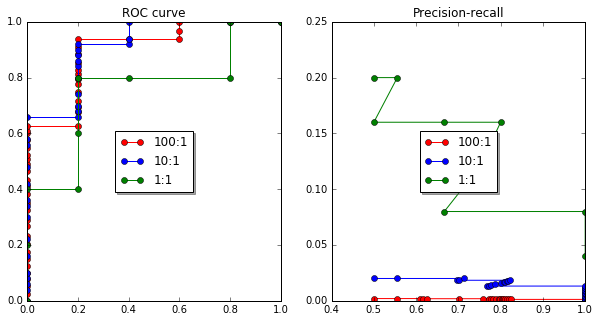

In [49]:
# combined view of the plots
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 5)
#ROC curves
ax[0].plot(simpoints1.fp,simpoints1.tp,'ro-')
ax[0].plot(simpoints2.fp,simpoints2.tp,'bo-')
ax[0].plot(simpoints3.fp,simpoints3.tp,'go-')
legend0 = ax[0].legend(['100:1','10:1','1:1'],loc='center', shadow=True)
ax[0].set_title('ROC curve')

# precision recall
ax[1].plot(simpoints1.pre,simpoints1.rec,'ro-')
ax[1].set_title('Precision-recall')
ax[1].plot(simpoints2.pre,simpoints2.rec,'bo-')
ax[1].plot(simpoints3.pre,simpoints3.rec,'go-')
legend1 = ax[1].legend(['100:1','10:1','1:1'],loc='center', shadow=True)
#?plt.legend

From the above plot we can see that ROC curve have an attractive property: they are insensitive to changes in the class distribution. If the proportion of positive to negative instances change in a test set, the ROC curve will not change. But the precision-recall curve will change dramatically. This property makes ROC curve a very robust critierion in comparing classification algorithms. 

# Part IV: Wrap up functions into a module for distribution

In [50]:
%%bash
mkdir ROC
mkdir ROC/ROC_curve_average

mkdir: ROC: File exists
mkdir: ROC/ROC_curve_average: File exists


In [51]:
%%file ./ROC/ROC.py

import numpy as np
import pandas as pd

def ROC_points(in_data):
    '''
    Function to generate ROC points for a bianry classifier on a given sample set with true lables and scores
    Input: a DataFrame with actual class label and scores
    Output:ROC points (tp rate, fp rate)
    '''
    
    ## sort the input data in descending order
    dat=in_data.sort_values(by=['score'],ascending=False)
    dat.index=range(dat.shape[0])
    ## compute # of positive labels and negative labels
    P=dat.label[dat.label==1].count()
    N=dat.label[dat.label==0].count()
    
    ## initialize tp and fp to 0
    tp=0
    fp=0
    ## initialize previous score to -inf
    f_prev=-np.inf
    
    ## create an empty stack
    result=[]
    
    ## compute ROC points increasing by fp rate
    for i in range(dat.shape[0]):
        if dat.score[i]!=f_prev:
            result.append((fp/N,tp/P))
            f_prev=dat.score[i]
        if dat.label[i]==1:
            tp+=1
        else:
            fp+=1
    result.append((fp/N,tp/P))
    
    return pd.DataFrame(result,columns=['fp','tp'])

Overwriting ./ROC/ROC.py


In [52]:
%%file ./ROC/roc_graph.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def roc_graph(input_rates,title=''):
    '''
    Function to plot the ROC curve and the shaded the area under the curve
    input rates: the ROC points of a classification result
    return: None, plot is generated
    '''
    
    points=input_rates
    
    fig, ax = plt.subplots()
    # plot the roc curve
    plt.plot(points.fp,points.tp,'o-')
    
    # set axis labels and title
    plt.xlabel('False positive rate',fontsize=15)
    plt.ylabel('True positive rate',fontsize=15)
    plt.title(title,fontsize=20)
    
    # shape the area under curve
    verts =  [(points.fp[0], 0)]+list(zip(points.fp,points.tp))+[(points.fp[len(points.fp)-1], 0)]
    poly = plt.Polygon(verts, facecolor='0.8', edgecolor='0.5')
    ax.add_patch(poly)
    
    # plot the 45 degree line in red
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x,'r')

Overwriting ./ROC/roc_graph.py


In [53]:
%%file ./ROC/AUC.py

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
    
def AUC(in_data):
    '''
    Function to calculate the area under an ROC curve 
    Input: a DataFrame with actual class label and scores
    Output: A, the area under the ROC curve. 0<A<1.0 
    '''
    
    ## sort the input data in descending order
    dat=in_data.sort_values(by=['score'],ascending=False)
    dat.index=range(dat.shape[0])
    ## compute # of positive labels and negative labels
    P=dat.label[dat.label==1].count()
    N=dat.label[dat.label==0].count()
    
    ## initialize tp and fp to 0
    tp=0
    fp=0
    
    ## initialize previous tp and fp to -inf
    tp_prev=0
    fp_prev=0
    
    ## initialize the AUC score to 0
    A = 0
    
    ## initialize previous score to -inf
    f_prev=-np.inf
    
    ## compute ROC points increasing by fp rate
    for i in range(dat.shape[0]):
        if dat.score[i]!=f_prev:
            A += TRAPEZOID_AREA(fp,fp_prev,tp,tp_prev)
            f_prev = dat.score[i]
            fp_prev = fp
            tp_prev = tp
               
        if dat.label[i]==1:
            tp+=1
        else:
            fp+=1
    
    A = A+TRAPEZOID_AREA(N,fp_prev,N,tp_prev)
    A = A/(P*N) # scale from P · N onto the unit square
    
    return A

Overwriting ./ROC/AUC.py


In [54]:
%%file ./ROC/ROC_curve_average/__init__.py

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def INTERPOLATE(ROCP1,ROCP2,X):
    '''
    Function to compute the slope for interpolation
    Input: two ROC curve points(ROCP1,ROCP2)
           X: target false postivie rate (FPR) 
    Return: The interpolated true positive rate for the given FPR
    '''
    
    slope=(ROCP2.tp-ROCP1.tp)/(ROCP2.fp-ROCP1.fp)
    return ROCP1.tp+slope*(X-ROCP1.fp)

def TPR_FOR_FPR(fpr_sample,ROC,npts):
    '''
    Function to find the largest true positive rate (TPR) for a given false positive rate (FPR)
    Input: fpr_sample (false positive rate fixed)
           ROC (a set of ROC points)
           npts(number of points in ROC)
    Output: The largest TPR or the interpolated TPR for the given FPR in a ROC curve
    '''
    i=1
    while(i<npts and ROC.fp[i] <= fpr_sample):
        i+=1
    
    if ROC.fp[i-1]==fpr_sample:
        return ROC.tp[i-1]
    else:
        return INTERPOLATE(ROC.ix[i-1],ROC.ix[i],fpr_sample)
    
def ROC_POINT_AT_THRESHOLD(ROC,thresh):
    '''
    Function to compute ROC point for a given threshold
    Input: ROC(ROC curve)
           thresh (threshold value)
    Output: ROC point at the given threshold
    '''
    
    for i in range(ROC.shape[0]):
        if ROC.score[i]<thresh:
            break    
    return ROC.ix[i]

Overwriting ./ROC/ROC_curve_average/__init__.py


In [55]:
%%file ./ROC/ROC_curve_average/vertical_average.py

def verticle_averaging(sample,ROCS,*karg):
    '''
    Function to compute the verticle averaging ROC points for input points of ROC curves
    Input:sample(number of false positive samples, the number of points along the x axis of the averaged ROC curve),
          ROCS(a list of multiple ROC curves, each curve is  stored in DataFrame and has 2 components:fp and tp)
    Output: the averaged ROC points
    '''

    # create an empty array to record result
    result=[]
    # number of roc cruves
    nrocs=len(ROCS)
    
    for fpr_sample in np.arange(0,(1+1/sample),1/sample):
        tprsum=0
        for i in range(nrocs):
            tprsum+=TPR_FOR_FPR(fpr_sample,ROCS[i],ROCS[i].shape[0])
        result.append((fpr_sample,tprsum/nrocs))
    #result.append((1,1))
    return pd.DataFrame(result,columns=['fp','tp'])

Overwriting ./ROC/ROC_curve_average/vertical_average.py


In [56]:
%%file ./ROC/ROC_curve_average/threshold_average.py

import numpy as np

def threshold_averaging(n_sample,ROCS,*karg):
    '''
    Function to compute the average ROC points based on threshold values
    Input: n_sample(number of thresholds considered)
           ROCS(a list of ROC curves, **** BUT ***** there must be a threshold column attached in every ROC curve)
    Output: ROC points of a threshold averaging curve
    '''
    
    # creat an empty array to store result
    # result consists of a set of points on ROC curve
    result=[]
    
    
    # create an empty numpy array to store all clustering score
    score=np.empty(1)
    for points in ROCS:
        score=np.r_[score,points.score]
    # sort the score in descending order    
    score=score[np.argsort(-score)]
    
    
    for tidx in np.arange(0,len(score),int(len(score)/n_sample)):
        fprsum=0
        tprsum=0
        for ROC in ROCS:
            p=ROC_POINT_AT_THRESHOLD(ROC,score[tidx])
            fprsum+=p.fp
            tprsum+=p.tp
        result.append((fprsum/len(ROCS),tprsum/len(ROCS)))
    
    return pd.DataFrame(result,columns=['fp','tp'])

Overwriting ./ROC/ROC_curve_average/threshold_average.py


In [57]:
%%file ./ROC/__init__.py
# import necessary modules

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def TRAPEZOID_AREA(x1,x2,y1,y2):
    '''
    Function to calculate the trapezoid area  
    Input: four vertex of the trapezoid 
    Output: the area of the trapezoid
    '''
    base = abs(x1-x2)
    height = (y1+y2)/2
    return base*height

Overwriting ./ROC/__init__.py


In [58]:
! ls -R ROC

AUC.py            ROC.py            dist
MANIFEST          ROC_curve_average roc_graph.py
README.txt        __init__.py       setup.py

ROC/ROC_curve_average:
__init__.py          threshold_average.py vertical_average.py

ROC/dist:
ROC-1.0.tar.gz


In [59]:
%%file ./ROC/setup.py
from distutils.core import setup

setup(name = "ROC",
      version = "1.0",
      author='Liqi Feng and Xin Liu',
      author_email='erinfeng1013@hotmail.com,xin.liu1@duke.edu',
      url='https://github.com/xinliu10/Sta663-Final-Project',
      py_modules = ['ROC','AUC','roc_graph'],
      packages = ['ROC_curve_average']
      )

Overwriting ./ROC/setup.py


In [60]:
%%file ./ROC/README.txt
This package were developed using Python 3.5.0 according to "An introduction to ROC analysis" by Fawcett 2005.
Name: ROC
Version: 1.0
Author: Liqi Feng, Xin Liu
Email: erinfeng1013@hotmail.com, xin.liu1@duke.edu
url: https://github.com/xinliu10/Sta663-Final-Project
        
This package contains 3 modules: 
1) ROC, 2) AUC, 3) roc_graph
and 1 subpackage:
1) ROC_curve_average
The subpackage contains 2 modules: 
1) vertical average, 2) threshold average

After downloading this package, it can be installed using !pip install ROC bash command. 

Overwriting ./ROC/README.txt


##### Build a source archive for distribution

In [61]:
%%bash

cd ROC
python setup.py sdist
cd -

running sdist
running check
writing manifest file 'MANIFEST'
creating ROC-1.0
creating ROC-1.0/ROC_curve_average
making hard links in ROC-1.0...
hard linking AUC.py -> ROC-1.0
hard linking README.txt -> ROC-1.0
hard linking ROC.py -> ROC-1.0
hard linking roc_graph.py -> ROC-1.0
hard linking setup.py -> ROC-1.0
hard linking ROC_curve_average/__init__.py -> ROC-1.0/ROC_curve_average
hard linking ROC_curve_average/threshold_average.py -> ROC-1.0/ROC_curve_average
hard linking ROC_curve_average/vertical_average.py -> ROC-1.0/ROC_curve_average
Creating tar archive
removing 'ROC-1.0' (and everything under it)
/Users/Erin/Documents/Courses/sta-663-2016/Sta663-Final-Project/Liqi-Feng-and-Xin-Liu_Fawcett-Final-Project/Liqi Feng and Xin Liu_Fawcett-Final Project


##### Distribution

In [62]:
%%bash

cp ROC/dist/ROC-1.0.tar.gz /tmp
cd /tmp
tar xzf ROC-1.0.tar.gz
cd ROC-1.0
python setup.py install

running install
running build
running build_py
copying ROC.py -> build/lib
copying AUC.py -> build/lib
copying roc_graph.py -> build/lib
copying ROC_curve_average/__init__.py -> build/lib/ROC_curve_average
copying ROC_curve_average/threshold_average.py -> build/lib/ROC_curve_average
copying ROC_curve_average/vertical_average.py -> build/lib/ROC_curve_average
running install_lib
copying build/lib/AUC.py -> /Users/Erin/anaconda/lib/python3.5/site-packages
copying build/lib/ROC.py -> /Users/Erin/anaconda/lib/python3.5/site-packages
copying build/lib/ROC_curve_average/__init__.py -> /Users/Erin/anaconda/lib/python3.5/site-packages/ROC_curve_average
copying build/lib/ROC_curve_average/threshold_average.py -> /Users/Erin/anaconda/lib/python3.5/site-packages/ROC_curve_average
copying build/lib/ROC_curve_average/vertical_average.py -> /Users/Erin/anaconda/lib/python3.5/site-packages/ROC_curve_average
copying build/lib/roc_graph.py -> /Users/Erin/anaconda/lib/python3.5/site-packages
byte-compil

##### Installation

User can download this package 'ROC-1.0.tar.gz' from https://github.com/xinliu10/Sta663-Final-Project. The guide for installation and use are in the README.txt file. 